# **WARNING**

In order for this notebook to run, you must first run the notebook `1_0_generate_noturn_data.ipynb` and generate the file `result/singlegame_results/player10_noturn_results.csv` which contains the optimal policy and value functions for the solved MDPs for different player skill model and epsilon combinatinos. It is also important to make sure that all combinations you want to analyse in this file were generated during this process. 


# 1.0 Notebook Parameters

Please specify the following variables:
1. `project_directory`: your project directory path
2. `epsilon_list`: the list of execution error multiplers (epsilon) that you want to consider in your analysis.
3. `player_id`: the players (i.e. skill model) you want to consider in your analysis; use one base model and scale it with different epsilons; this should match whatever was used in `1_0_generate_noturn_data.ipynb`.

In [1]:
# Change this to the project directory path for your computer  
project_directory = '/Users/rachael/Desktop/darts-thesis'

# Set the epsilons that will be considered in this analysis 
epsilon_list = [1,2,3,4,5,6,7,8,9]

# Set the ID of the player skill models you want to use 
    # 10 - symmetric DB skill model that we were using up until now 
    # ? - "average pro" skill model generated by H & W 
player_id = 10 


# 2.0 Notebook Setup

In [2]:
# Import and configure modules from this project

import os

os.chdir(project_directory)

import function_init_simple_mdp as imdp
import function_helpers_singleplayer as h

import class_handicap as hc 
handicap = hc.Handicap(results_file_name='./result/singlegame_results/player10_noturn_results.csv', epsilon_list = epsilon_list)

# import function_init_baoard as fb
# import function_init_simple_mdp as imdp


/Users/rachael/miniconda3/envs/darts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Import and configure external modules

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm, colors
import seaborn as sns

# sns.set_theme() # uncomment if you want the seaborn visual theme

def color_map_color(value, cmap_name='Wistia', vmin=0, vmax=1):
    # norm = plt.Normalize(vmin, vmax)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = colors.rgb2hex(rgb)
    return color


In [4]:
# Helper functions 

def linear_interpolation(x1,x2,y1,y2,y):
    x = x1 - ((y1-y)/(y1-y2))*(x1-x2)
    return x 

# 3.0 Load Data

In [5]:
# Load data
df = pd.read_csv('result/singlegame_results/player10_noturn_results.csv')
df = df.loc[df.player==player_id]

# Read only the relevant columns - note that this will result in duplicates if you include multiple players 
df = df[['epsilon','tokens','score','optimal_value','optimal_policy']]

# Map to policy action names 
a_map = {i:imdp.a_list[i] for i in range(len(imdp.a_list))}
df['optimal_policy_name'] = df['optimal_policy'].map(a_map)

# 4.0 Points Per Dart (PPD)

In [6]:
# Get the total expected throws V(501,0) for each epsilon in the list 
expected_throws_list = []

for epsilon in epsilon_list: 
    th = df.loc[(df.score==501) & (df.epsilon==epsilon) & (df.tokens==0)].optimal_value.values[0]
    expected_throws_list.append(th)

# Calculate the estimated points per dart (PPD) for each player by dividing 501 by their total expected throws 
ppd_list = [501 / expected_throws_list[i] for i in range(len(expected_throws_list))]


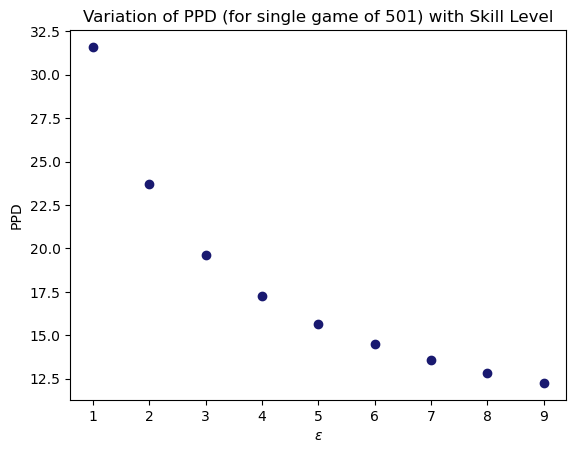

In [7]:
# Examine how PPD changes with epsilon 
fig = plt.scatter(epsilon_list,ppd_list,color='midnightblue')
fig = plt.xlabel(r'$\epsilon$')
fig = plt.ylabel('PPD')
fig = plt.title("Variation of PPD (for single game of 501) with Skill Level")


In [8]:
# Get dataframe for when players have no tokens 
df0 = df.loc[df.tokens==0].copy()

# Add a column for estimated PPD for remaining game
df0['ppd'] = df0.score / df0.optimal_value

# Create dataframes for each epsilon value in our desired list
epsilon_ppd_dfs = []

for epsilon in epsilon_list:
    
    temp = df0.loc[df0.epsilon==epsilon].set_index('score')['ppd'].copy()
    epsilon_ppd_dfs.append(temp)


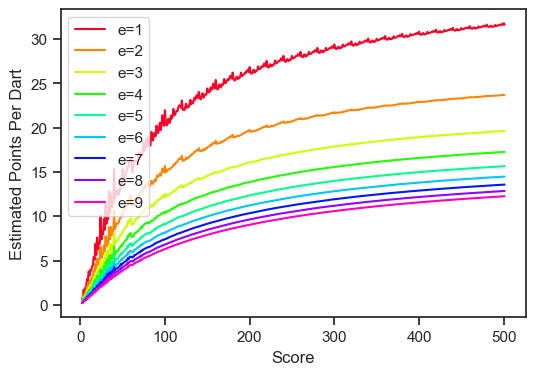

In [9]:
# Housekeeping
e_leg = [] # Create a placeholder list for legend 
vmax=max(epsilon_list) # Set max epsilon for color scale
vmin=min(epsilon_list) # Set min epsilon for color scale

# Set figure size
fig = sns.set(rc={'figure.figsize':(6,4)},style='ticks') # revert to default theme after heatmap plots

# Plot line for each epsilon value 
for e in range(len(epsilon_list)):
    epsilon = epsilon_list[e]
    e_leg.append('e={}'.format(epsilon))
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    fig = plt.plot(epsilon_ppd_dfs[e],color=color)

# Legend and axis labels
#fig = plt.title('Change in points per dart as the game progresses for players of different skill levels')
fig = plt.xlabel('Score')
fig = plt.ylabel('Estimated Points Per Dart')
fig = plt.legend(e_leg)

# 5.0 Heuristic Spot Point Evaluation

In [10]:
# Get the estimated starting score for the weaker player "starting score weaker" (SSW)
ssw_list = []

# For each stronger epsilon  
for s in range(len(ppd_list)):

    # For each weaker epsilon (i.e. e_weaker >= e_stronger as specified through range of for loop)
    for w in range(s,len(ppd_list)):

        sppd = ppd_list[s] # stronger player's ppd 
        wppd = ppd_list[w] # weaker player's ppd 

        ssw = round(501*(wppd/sppd)) # calculate starting score for weaker player using spot point heuristic 

        ssw_list.append([epsilon_list[s],epsilon_list[w],ssw])

#ssw_list

In [11]:
# List to contain all data about spot points and their efficacy - will be turned into a df 
ssw_list_full = []

for ssw in ssw_list: 

    # Get the expected number of throws for the stronger player with no tokens 
    th1 = df.loc[(df.score==501) & (df.epsilon==ssw[0]) & (df.tokens==0)].optimal_value.values[0]

    # Get the expected number of throws for the weaker player with no tokens 
    th2 = df.loc[(df.score==ssw[2]) & (df.epsilon==ssw[1]) & (df.tokens==0)].optimal_value.values[0]

    # Record this in the list 
    ssw_list_full.append([ssw[0],ssw[1],ssw[2],th1,th2, th2-th1])

# Consolidate into a df 
spot_point_df = pd.DataFrame(ssw_list_full,columns=['p1_epsilon','p2_epsilon','p2_starting_score','p1_expected_throws','p2_expected_throws','diff_expected_throws'])
spot_point_df.head()  

,p1_epsilon,p2_epsilon,p2_starting_score,p1_expected_throws,p2_expected_throws,diff_expected_throws
0,1,1,501,15.854003,15.854003,0.000000
1,1,2,376,15.854003,16.606544,0.752541
2,1,3,311,15.854003,17.276087,1.422085
3,1,4,274,15.854003,18.018940,2.164937
4,1,5,248,15.854003,18.723984,2.869981


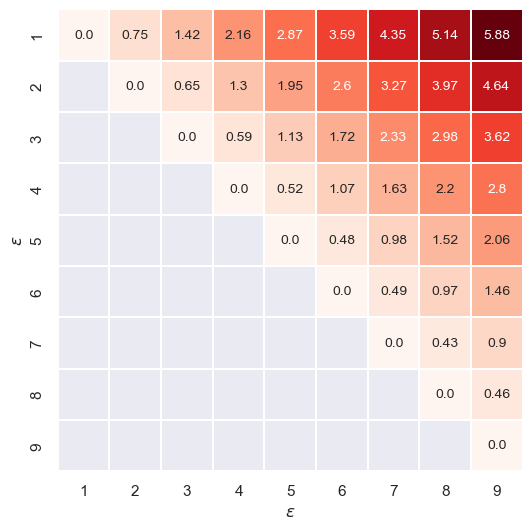

In [12]:
# Restructure the dataframe so that it can be plotted as a heatmap 
heuristic_spot_point_effectiveness = spot_point_df.pivot(index='p1_epsilon',columns='p2_epsilon',values='diff_expected_throws')

# Round to two decimal places for visual ease
heuristic_spot_point_effectiveness = heuristic_spot_point_effectiveness.round(2)

# Set figure size
fig = sns.set(rc={'figure.figsize':(6,6)})

# Plot heatmap 
fig = sns.heatmap(heuristic_spot_point_effectiveness,annot=True,annot_kws={"size": 10},fmt="",cmap='Reds',linewidths=0.30,cbar=False)

# Title and axis labels
#fig = plt.title("Difference in expected throws using spot point handicap system")
fig = plt.xlabel(r'$\epsilon$')
fig = plt.ylabel(r'$\epsilon$')


In [13]:
# Create dataframes for values at 501 for each token value 
epsilon_value_dfs = []

for e in range(len(epsilon_list)):
    epsilon = epsilon_list[e]
    temp = df0.loc[df0.epsilon==epsilon].set_index('score')['optimal_value'].copy()
    epsilon_value_dfs.append(temp)


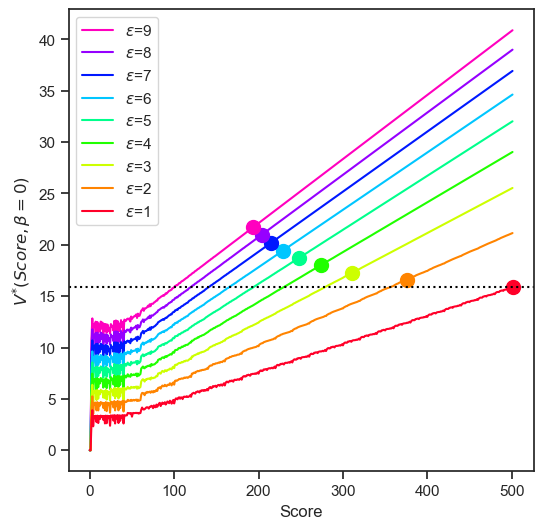

In [14]:
# Housekeeping
e_leg = [] # Create a placeholder list for legend 
vmax=max(epsilon_list) # Set max epsilon for color scale
vmin=min(epsilon_list) # Set min epsilon for color scale

# Set figure size
fig = sns.set(rc={'figure.figsize':(6,6)},style='ticks')


# Plot line for each epsilon value 
for e in reversed(range(len(epsilon_list))): # reverse order so legend is more intuitive
    epsilon=epsilon_list[e] # get actual epsilon value  
    e_leg.append('$\epsilon$={}'.format(epsilon)) # append the current epsilon to the legend list
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax) # get the color for current epsilon 
    fig = plt.plot(epsilon_value_dfs[e],color=color) # plot the line 

# Plot markers for spot estimated point handicap 
for e in range(len(epsilon_list)):
    epsilon = epsilon_list[e]
    color = color_map_color(epsilon, cmap_name='gist_rainbow', vmin=vmin, vmax=vmax)
    s = spot_point_df.loc[(spot_point_df.p1_epsilon==1) & (spot_point_df.p2_epsilon==epsilon)]['p2_starting_score'].values[0]
    fig = plt.plot(s, epsilon_value_dfs[e][s], marker="o", markersize=10, color=color)

# Legend and axis labels
fig = plt.xlabel('Score')
fig = plt.ylabel(r'$V^{*}(Score,\beta=0)$')
fig = plt.legend(e_leg)


# Uncomment for black dotted line at epsilon 1's V(501,0)
fig = plt.axhline(epsilon_value_dfs[0][501],color='black',linestyle='dotted') 


# 6.0 New Dynamic Credit Handicap

In [15]:
# List of all handicap values 
dynamic_credit_handicap_list = []

# Iterate through all combinations of epsilon and record credit handicap 
for s in epsilon_list:

    dynamic_credit_handicap_sub_list = []

    for w in epsilon_list:

        if w >= s: # remove duplicates, only record where w is weaker than or equal to s
            handicap_value = handicap.get_dynamic_credits_handicap(s,w)
            dynamic_credit_handicap_sub_list.append(handicap_value)
        else: 
            dynamic_credit_handicap_sub_list.append(np.nan) # use nan as fillers when this criteria is not met
    
    dynamic_credit_handicap_list.append(dynamic_credit_handicap_sub_list)

# Create dataframe
df_dynamic_credit_handicap = pd.DataFrame(dynamic_credit_handicap_list)

# Fix column and index names and round values for readability 
df_dynamic_credit_handicap.index = epsilon_list 
df_dynamic_credit_handicap.columns = epsilon_list
df_dynamic_credit_handicap = df_dynamic_credit_handicap.round(2)

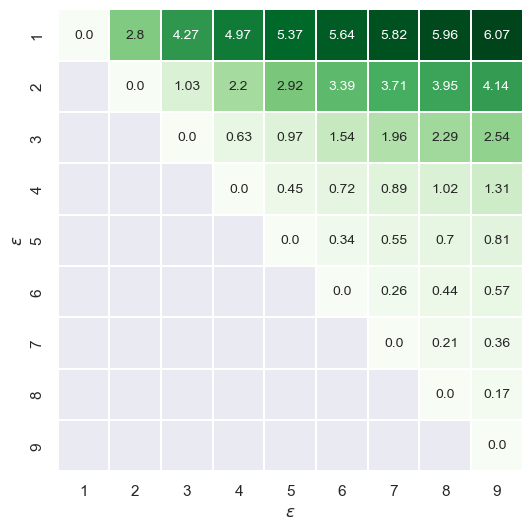

In [16]:
# Set figure size 
fig = sns.set(rc={'figure.figsize':(6,6)})

# Plot heatmap 
fig = sns.heatmap(df_dynamic_credit_handicap,annot=True,annot_kws={"size": 10},fmt="",cmap='Greens',linewidths=0.30,cbar=False)

# Axis labels
fig = plt.xlabel(r'$\epsilon$')
fig = plt.ylabel(r'$\epsilon$')

# 7.0 New Optimized Spot Point

In [17]:
########################################
# Variables 

# If this is true then the values will be the starting score of the weaker player
# Otherwise, it will display the actual number of spotted points
display_starting_score = True 

########################################

# List of all handicap values 
optimized_spot_point_handicap_list = []

# Iterate through all combinations of epsilon and record credit handicap 
for s in epsilon_list:

    optimized_spot_point_handicap_sub_list = []

    for w in epsilon_list:

        if w >= s: # remove duplicates, only record where w is weaker than or equal to s
            handicap_value = handicap.get_spot_point_optimal_handicap(s,w)
            if display_starting_score==True:
                handicap_value=501-handicap_value
            optimized_spot_point_handicap_sub_list.append(handicap_value)
        else: 
            optimized_spot_point_handicap_sub_list.append(np.nan) # use nan as fillers when this criteria is not met
    
    optimized_spot_point_handicap_list.append(optimized_spot_point_handicap_sub_list)

# Create dataframe
df_optimized_spot_point_handicap = pd.DataFrame(optimized_spot_point_handicap_list)

# Fix column and index names and round values for readability 
df_optimized_spot_point_handicap.index = epsilon_list 
df_optimized_spot_point_handicap.columns = epsilon_list
df_optimized_spot_point_handicap = df_optimized_spot_point_handicap.round(2)

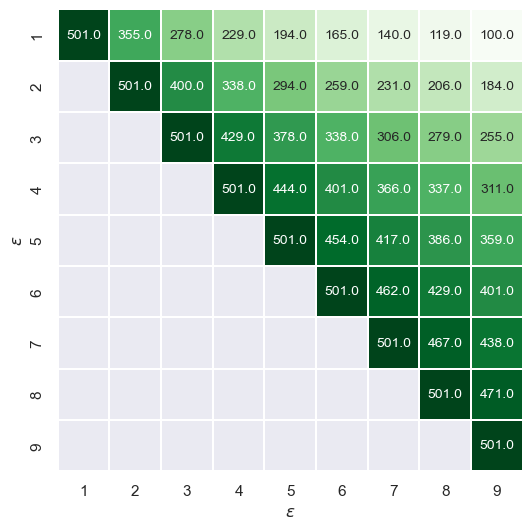

In [34]:

# Set figure size 
fig = sns.set(rc={'figure.figsize':(6,6)})

# Plot heatmap 
fig = sns.heatmap(df_optimized_spot_point_handicap,annot=True,annot_kws={"size": 10},fmt="",cmap='Greens',linewidths=0.30,cbar=False)

# Axis labels
fig = plt.xlabel(r'$\epsilon$')
fig = plt.ylabel(r'$\epsilon$')


# 8.0 New Optimized Spot Dart

In [26]:
# List of all handicap values 
optimized_spot_dart_handicap_list = []

# Iterate through all combinations of epsilon and record credit handicap 
for s in epsilon_list:

    optimized_spot_dart_handicap_sub_list = []

    for w in epsilon_list:

        if w >= s: # remove duplicates, only record where w is weaker than or equal to s
            handicap_value = handicap.get_spot_dart_optimal_handicap(s,w)

            optimized_spot_dart_handicap_sub_list.append(handicap_value)
        else: 
            optimized_spot_dart_handicap_sub_list.append(np.nan) # use nan as fillers when this criteria is not met
    
    optimized_spot_dart_handicap_list.append(optimized_spot_dart_handicap_sub_list)

# Create dataframe
df_optimized_spot_dart_handicap = pd.DataFrame(optimized_spot_dart_handicap_list)

# Fix column and index names and round values for readability 
df_optimized_spot_dart_handicap.index = epsilon_list 
df_optimized_spot_dart_handicap.columns = epsilon_list
df_optimized_spot_dart_handicap = df_optimized_spot_dart_handicap.round(2)

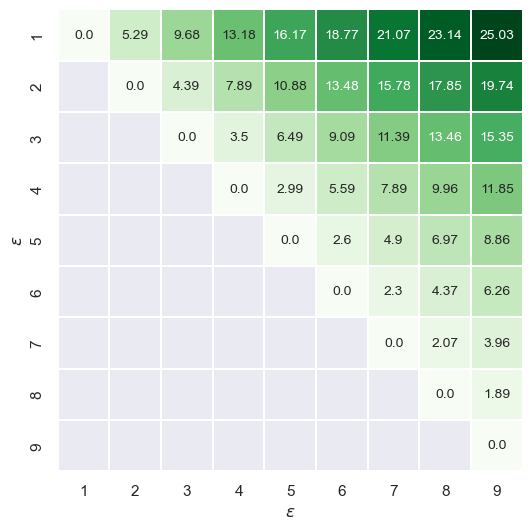

In [27]:

# Set figure size 
fig = sns.set(rc={'figure.figsize':(6,6)})

# Plot heatmap 
fig = sns.heatmap(df_optimized_spot_dart_handicap,annot=True,annot_kws={"size": 10},fmt="",cmap='Greens',linewidths=0.30,cbar=False)

# Axis labels
fig = plt.xlabel(r'$\epsilon$')
fig = plt.ylabel(r'$\epsilon$')
